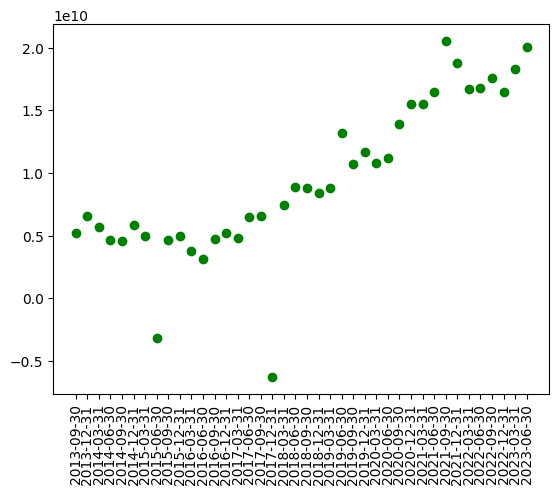

In [26]:
from OutsideWorld.Finance import Stock

a = Stock.Stock()

b = a.get_historical_cash_flow_statement("MSFT")
import matplotlib.pyplot as plt
df = b[b["calendarYear"] > "2013"].sort_index()
x = df.index
y = df["netIncome"] * 1

plt.plot(x,y,'go')
plt.xticks(rotation=90)
plt.show()

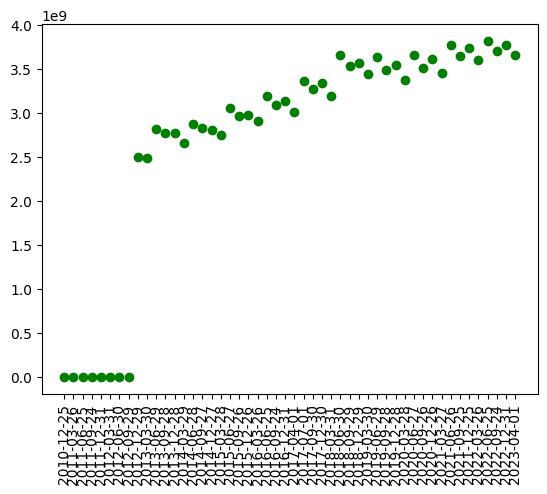

In [15]:
import matplotlib.pyplot as plt
df = b[b["calendarYear"] > "2010"].sort_index()
x = df.index
y = df["dividendsPaid"] * -1

plt.plot(x,y,'go')
plt.xticks(rotation=90)
plt.show()


,open,high,low,close,volume
date,,,,,
2021-01-04,155.81,155.8100,152.0200,153.29,326388
2021-01-05,151.91,153.4000,151.7500,153.40,238962
2021-01-06,152.71,154.1700,152.4800,153.53,298558
2021-01-07,151.66,152.7000,151.5100,152.67,350942
2021-01-08,153.60,154.0600,152.1100,152.85,423329
...,...,...,...,...,...
2023-07-26,165.16,166.0165,164.8800,165.70,162291
2023-07-27,165.87,166.7290,165.3800,165.43,182305
2023-07-28,167.10,167.8000,166.6900,167.15,292281


NameError: name 'c' is not defined

In [4]:
from pipelines.prices import fetch_prices
import awswrangler as wr

fetch_prices(["BAH", "JCI"])



,open,high,low,close,volume
date,,,,,
2019-01-02,114.68,116.530,114.6800,116.28,169986
2019-01-03,115.85,116.280,114.2900,114.65,309592
2019-01-04,117.94,120.170,117.5057,119.73,307713
2019-01-07,120.71,122.180,120.3200,121.28,156125
2019-01-08,123.16,123.480,121.9600,122.31,150570
...,...,...,...,...,...
2023-07-27,165.87,166.729,165.3800,165.43,182305
2023-07-28,167.10,167.800,166.6900,167.15,292281
2023-07-31,168.00,168.570,167.8136,168.24,202470


In [2]:
c.index.max()

'2023-08-02'

In [2]:
c.index.min()

'2019-01-02'

In [5]:
c = wr.s3.read_csv("s3://faysal/stocks/prices/JCI.csv").set_index(["date"])
display(c)


,open,high,low,close,volume
date,,,,,
2019-01-02,29.30,30.510,29.16,30.50,5292301
2019-01-03,30.32,30.725,29.95,30.01,5646302
2019-01-04,30.42,31.400,30.42,31.21,6400412
2019-01-07,31.33,32.040,31.20,31.72,5555074
2019-01-08,32.10,32.400,31.53,31.94,5591749
...,...,...,...,...,...
2023-07-27,69.15,70.060,68.89,69.32,4286128
2023-07-28,69.85,69.900,69.17,69.19,3767320
2023-07-31,69.40,69.720,69.17,69.55,3466297
